# Monet GAN Assignment

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, datasets
from tensorflow.keras.activations import sigmoid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2025-02-28 12:34:07.465914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740771247.482450    4564 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740771247.487576    4564 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 12:34:07.505545: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load The Data

In [2]:
MONET_FILENAMES = tf.io.gfile.glob('data/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('data/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [3]:
raw_monet_dataset = tf.data.TFRecordDataset(MONET_FILENAMES)
raw_photo_dataset = tf.data.TFRecordDataset(PHOTO_FILENAMES)

I0000 00:00:1740771250.068925    4564 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5


Based on above, there are 3 features: 
- the target that is either monet or photo
- the image_name
- the image
Since I'm using tf records, they're all stored as serialized strings

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [4]:
# We need to parse the bytelist representation of the string into a valid image.
IMAGE_SIZE = [256, 256]

def _parse_image_function(record):
    feature_description = {
    'target': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    }
    example = tf.io.parse_single_example(record, feature_description)
    image = decode_image(example['image'])
    return image

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image
    
def parse_data_set(dataset):
    return dataset.map(_parse_image_function)

In [5]:
parsed_monet_dataset = parse_data_set(raw_monet_dataset).batch(1)
parsed_photo_dataset = parse_data_set(raw_photo_dataset).batch(1)

In [6]:
parsed_monet_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

## EDA

monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [7]:
example_monet = next(iter(parsed_monet_dataset))
example_photo = next(iter(parsed_photo_dataset))

2025-02-28 12:34:10.420599: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


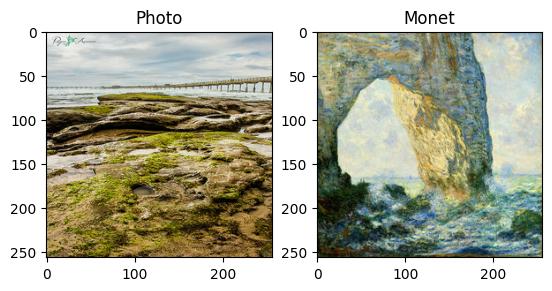

In [8]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

### Build the model

In [9]:
def downsample_layer(filters, size):
    result = Sequential([
        layers.Conv2D(filters, size, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU()
    ])
    return result

def upsample_layer(filters, size):
    result = Sequential([
        layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU()
    ])
    return result

In [10]:
def Generator():
    OUTPUT_CHANNELS=3
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample_layer(64, 4),
        downsample_layer(128, 4),
        downsample_layer(256, 4),
        downsample_layer(512, 4),
        downsample_layer(512, 4)
    ]

    up_stack = [
        upsample_layer(512, 4),
        upsample_layer(512, 4),
        upsample_layer(256, 4),
        upsample_layer(128, 4),
        upsample_layer(64, 4)
    ]

    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', activation='tanh')
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [11]:
def Discriminator():
    inputs = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inputs

    down_stack = [
        downsample_layer(64, 4),
        downsample_layer(128, 4),
        downsample_layer(256, 4),
        downsample_layer(512, 4)
    ]
    for down in down_stack:
        x = down(x)
    norm = layers.BatchNormalization()(x)
    leaky_relu = layers.LeakyReLU()(norm)
    last = layers.Conv2D(1, 4, strides=1)(leaky_relu)

    return tf.keras.Model(inputs=inputs, outputs=last)

In [12]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

# Define optimizers
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [13]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [14]:
LAMBDA = 10

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [15]:
cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

### Fit/Train
(Largely Based on Monet CycleGAN Tutorial, because this was a huge step in complexity)

In [16]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((parsed_monet_dataset, parsed_photo_dataset)),
    epochs=25
)

Epoch 1/25


I0000 00:00:1740771270.589465    4679 service.cc:148] XLA service 0x7fd68c003610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740771270.589509    4679 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-02-28 12:34:31.452416: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740771274.660288    4679 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-28 12:34:36.909856: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 17.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-28 12:34:36.927416: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran

300/300 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - monet_disc_loss: 0.7428 - monet_gen_loss: 7.2347 - photo_disc_loss: 0.7352 - photo_gen_loss: 7.3098
Epoch 2/25
  1/300 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - monet_disc_loss: 0.7957 - monet_gen_loss: 6.2241 - photo_disc_loss: 0.8285 - photo_gen_loss: 6.8951

2025-02-28 12:35:14.193445: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-02-28 12:35:14.193745: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/malcolm/msds_projects/kaggle_monet/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - monet_disc_loss: 0.7022 - monet_gen_loss: 6.3252 - photo_disc_loss: 0.6990 - photo_gen_loss: 6.3905
Epoch 3/25
  2/300 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - monet_disc_loss: 0.7420 - monet_gen_loss: 5.1795 - photo_disc_loss: 0.9284 - photo_gen_loss: 5.2004 

2025-02-28 12:35:36.569010: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - monet_disc_loss: 0.6965 - monet_gen_loss: 5.9365 - photo_disc_loss: 0.6904 - photo_gen_loss: 5.9906
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - monet_disc_loss: 0.6911 - monet_gen_loss: 5.6979 - photo_disc_loss: 0.6817 - photo_gen_loss: 5.7612
Epoch 5/25
  1/300 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - monet_disc_loss: 0.7491 - monet_gen_loss: 5.1176 - photo_disc_loss: 0.9169 - photo_gen_loss: 5.5761

2025-02-28 12:36:25.017698: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - monet_disc_loss: 0.6561 - monet_gen_loss: 5.6088 - photo_disc_loss: 0.6681 - photo_gen_loss: 5.6165
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - monet_disc_loss: 0.4035 - monet_gen_loss: 6.7372 - photo_disc_loss: 0.6271 - photo_gen_loss: 5.8318
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - monet_disc_loss: 0.2646 - monet_gen_loss: 7.7487 - photo_disc_loss: 0.6075 - photo_gen_loss: 5.9143
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - monet_disc_loss: 0.2835 - monet_gen_loss: 7.9799 - photo_disc_loss: 0.4584 - photo_gen_loss: 6.7404
Epoch 9/25
  2/300 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - monet_disc_loss: 0.9998 - monet_gen_loss: 5.7134 - photo_disc_loss: 0.0616 - photo_gen_loss: 7.6336 

2025-02-28 12:37:56.386340: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - monet_disc_loss: 0.3372 - monet_gen_loss: 7.8942 - photo_disc_loss: 0.3789 - photo_gen_loss: 6.9830
Epoch 10/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - monet_disc_loss: 0.3736 - monet_gen_loss: 7.1823 - photo_disc_loss: 0.3895 - photo_gen_loss: 6.7375
Epoch 11/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - monet_disc_loss: 0.3131 - monet_gen_loss: 7.2850 - photo_disc_loss: 0.4331 - photo_gen_loss: 6.4032
Epoch 12/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - monet_disc_loss: 0.2480 - monet_gen_loss: 8.1549 - photo_disc_loss: 0.3918 - photo_gen_loss: 6.5862
Epoch 13/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - monet_disc_loss: 0.3382 - monet_gen_loss: 7.2357 - photo_disc_loss: 0.3685 - photo_gen_loss: 6.5273
Epoch 14/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - monet_disc_loss: 0.2517 - monet_gen_loss: 7.8399 - photo_disc_loss: 0.3443 - photo_gen_loss: 6.6266
Epoch 15/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - monet_disc_lo

2025-02-28 12:41:04.993545: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - monet_disc_loss: 0.3440 - monet_gen_loss: 6.9787 - photo_disc_loss: 0.3566 - photo_gen_loss: 6.3676
Epoch 18/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - monet_disc_loss: 0.2813 - monet_gen_loss: 7.0838 - photo_disc_loss: 0.3371 - photo_gen_loss: 6.3314
Epoch 19/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - monet_disc_loss: 0.3275 - monet_gen_loss: 6.8798 - photo_disc_loss: 0.3580 - photo_gen_loss: 6.4824
Epoch 20/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - monet_disc_loss: 0.2742 - monet_gen_loss: 7.2962 - photo_disc_loss: 0.4145 - photo_gen_loss: 5.8423
Epoch 21/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - monet_disc_loss: 0.3162 - monet_gen_loss: 6.5180 - photo_disc_loss: 0.3398 - photo_gen_loss: 6.0549
Epoch 22/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - monet_disc_loss: 0.3023 - monet_gen_loss: 6.8188 - photo_disc_loss: 0.4068 - photo_gen_loss: 5.7857 
Epoch 23/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - monet_disc_l

## generate test data

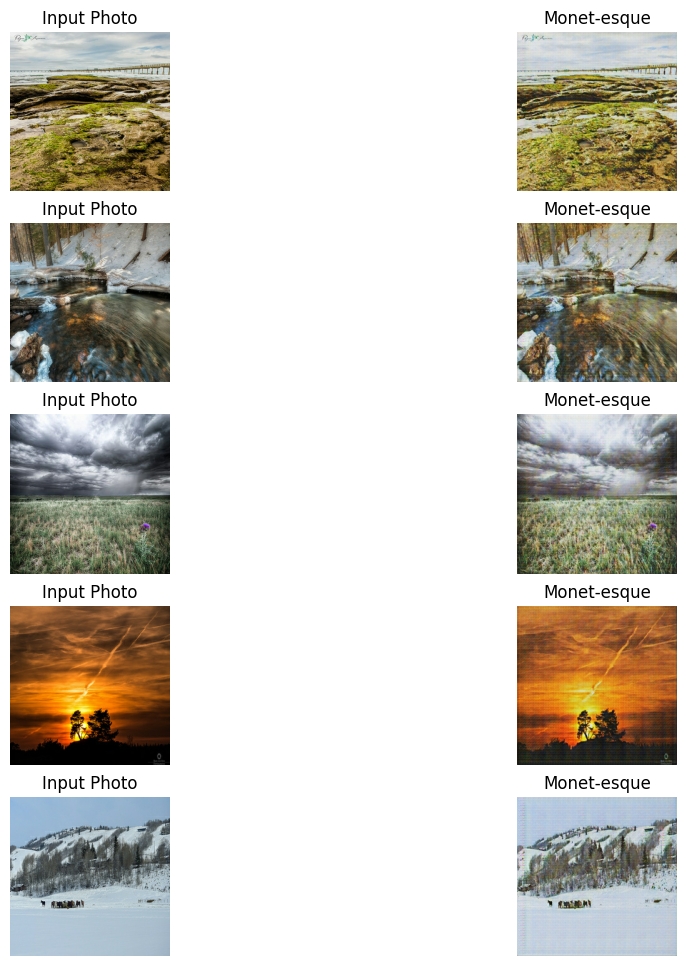

In [22]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(parsed_photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

You are going to generate 7,000-10,000 Monet-style images that are in jpg format. Their sizes should be 256x256x3 (RGB). Then you need to zip those images and your output from your Kernel should only have ONE output file named images.zip.

I decided to zip the images to submit to kaggle

In [23]:
import PIL

In [24]:
i = 1
for img in parsed_photo_dataset:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1

## References

Thank god for this page: Monet CycleGAN Tutorial
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
Lifesaving

More General Writeups, big picture.
- https://codezup.com/generative-adversarial-networks-gans-python-tensorflow/
- https://www.digitalocean.com/community/tutorials/implementing-gans-in-tensorflow